# Q2. What are the top topics in guest reviews?

## Table of Contents: 


* [Topic Modeling: Latent Dirichlet Allocation (LDA)](#chapter4_)
    * [Cleaning and Pre-processing data for LDA](#chapter4_1)
    * [Train LDA Topic Model](#chapter4_2)
        * [Select the Optimal Number of Topics](#chapter4_2_2)
        * [Build LDA Model and Interpret Results](#chapter4_2_3)
        * [Evaluate LDA Model](#chapter4_2_4)
    * [Visualize topic-keyword of LDA](#chapter4_3)

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")


import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en.examples import sentences

import pickle 

from nltk.tokenize import word_tokenize


import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.models import Phrases,CoherenceModel, LdaModel

import pyLDAvis.gensim_models
import pyLDAvis
import pyLDAvis.sklearn

#from imp import reload
import importlib

import time

from tabulate import tabulate
import re

[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter4_'></a>
# Topic Modeling: Latent Dirichlet Allocation (LDA)

<a class="anchor" id='chapter4.1'></a>
## Cleaning and Pre-processing data for LDA

For this analysis, we further clean and pre-process reviews following these steps:<br>
1. Lemmatize <br>
2. Remove punctuation <br>
3. Remove stop words <br>
4. Remove numbers <br>
5. Keep words with length > 2 <br>
6. Tokenize <br>

Then, we convert text into a bag of words as a dictionary, where to each word (key) is associated a numeric id (value). And finally, we count the number of times each word occurs within the corpus.

Packages required: <br>
- spacy
- nltk.tokenize
- gensim.corpora

In [2]:
# Upload data

df_reviews_sample_sentiment_bitrigrams = pd.read_pickle('./data/df_reviews_sample_sentiment_bitrigrams.pkl')

In [3]:
df_reviews_sample_sentiment_bitrigrams.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,length_comments,language,comments_english,polarity_compound,sentiment
39978,735370,151499476,2017-05-13,107924476,Jutta,eine schön gelegene wohnung in der etage die w...,59,de,a beautifully located apartment on the same fl...,0.0258,neu
196555,5909451,142261214,2017-04-07,118986470,Michael,alles bestens sehr gute lage nahe der piazza d...,25,de,"everything was very good, very good location n...",0.8803,pos
340512,14976201,437134397,2019-04-14,129853528,Kristine,das airbnb hat uns sehr gut gefallen wir haben...,120,de,"We liked the airbnb very much, although we onl...",0.9154,pos
189256,5745043,658966293,2020-08-31,160489786,Mark,perfekt für einen urlaub in florenz und der an...,15,de,perfect for a vacation in florence and traveli...,0.5719,pos
149460,4143454,179633637,2017-08-08,97926976,Uwe,wir hatten als familie pesonen eine sehr schö...,96,de,we had a very nice time as a family pesonen in...,0.9432,pos


In [4]:
df_reviews_sample_sentiment_bitrigrams.shape

(51047, 11)

In [5]:
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])

In [6]:
def pre_process_text(text):
    
    '''Clean and pre-process data.
    '''
    
    cleaned_text = []
    document = nlp.pipe(text, batch_size=256, n_process=6)
    for doc in document:
        text = [
            token.lemma_
            for token in doc
            if not token.is_punct
            and not token.is_stop
            and not token.like_num
            and token.is_alpha
            and len(token.orth_) > 2
        ]
        cleaned_text.append(" ".join(text).lower())
    return cleaned_text

In [7]:
def sentence_to_words(cleaned_text):
    
    '''Tokenize data
    '''
    
    data_words = []
    for sentence in cleaned_text:
        item = word_tokenize(sentence)
        data_words.append(item)
    return data_words

In [8]:
def prepare_data_words(data):
    
    '''Clean and pre-process data.
    
    Prepare Dictionary and Corpus for LDA.
    
    Dictionary: Unique ids for each unique word
    Corpus: Word document frequency
    '''
    
    # Pre-process text data
    data_clean = pre_process_text(data)
    
    # Tokenize text data
    data_words = sentence_to_words(data_clean)
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_words)
    
    # Filter extreme values
    # no_below (int) filters out words appearing less than n times
    # no_above (float) filters out words appearing in more than x% of all reviews
    id2word.filter_extremes(no_below=5, no_above=0.1) 
  
    # Create Corpus
    texts = data_words
    
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return id2word, corpus, data_words

In [9]:
# Convert reviews to list

reviews_list = df_reviews_sample_sentiment_bitrigrams['comments_english'].to_list()

In [10]:
id2word, corpus, data_words = prepare_data_words(reviews_list);

[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter4_2'></a>
## Train LDA Topic Model

**Packages** required: <br>
- gensim https://pypi.org/project/gensim/


<a class="anchor" id='chapter4.2.2'></a>
### Select the Optimal Number of Topics

In [11]:
# Optimize the number of topics
start_time = time.time()
coherence = []
for k in range(1,11):
    print('Round: '+str(k))
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=k,
                                       chunksize=100,
                                       passes=10,
                                       iterations=200,
                                       random_state=42,
                                       per_word_topics=True)


    
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model, texts=data_words,
                                                     dictionary=id2word, coherence='c_v')
    coherence.append((k,cm.get_coherence()))
    ## Print time taken to train the model
    print("--- %s seconds ---" % (time.time() - start_time))



Round: 1
--- 5.7380530834198 seconds ---
Round: 2
--- 19.069741010665894 seconds ---
Round: 3
--- 34.50109601020813 seconds ---
Round: 4
--- 51.365859031677246 seconds ---
Round: 5
--- 68.14608097076416 seconds ---
Round: 6
--- 84.78217005729675 seconds ---
Round: 7
--- 101.90255808830261 seconds ---
Round: 8
--- 119.27384901046753 seconds ---
Round: 9
--- 136.63148999214172 seconds ---
Round: 10
--- 154.5361888408661 seconds ---


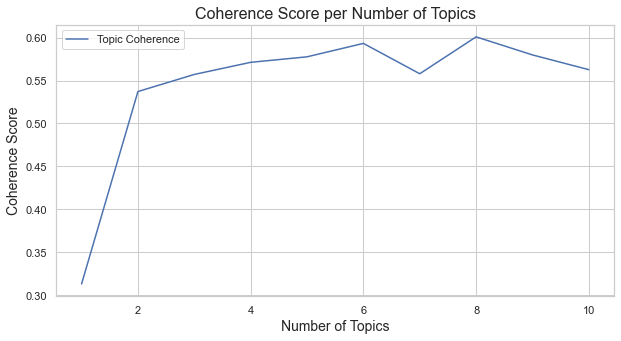

In [12]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.figure(figsize=(10,5))
ax = sns.lineplot(x=x_val, y=y_val, label='Topic Coherence')

ax.axes.set_title('Coherence Score per Number of Topics', fontsize=16)
ax.set_ylabel('Coherence Score', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.show()   

The ideal **number of topics** will **maximize coherence**, in our case **8** can be a reasonable choice.

<a class="anchor" id='chapter4.2.3'></a>
### Build LDA Model and Interpret Results

In [13]:
# number of topics
num_topics = 8

# Build LDA model
lda_model_final = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       chunksize=200,
                                       passes=40,
                                       random_state=617,
                                       per_word_topics=True)

# Print the Keyword in the 8 topics
print(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

[(0, '0.057*"view" + 0.044*"flat" + 0.036*"amazing" + 0.031*"lovely" + 0.030*"terrace" + 0.022*"enjoy" + 0.021*"wonderful" + 0.020*"love" + 0.018*"definitely" + 0.017*"fantastic"'), (1, '0.024*"distance" + 0.019*"attraction" + 0.018*"away" + 0.016*"area" + 0.015*"main" + 0.015*"tourist" + 0.014*"walking" + 0.013*"duomo" + 0.013*"shop" + 0.012*"right"'), (2, '0.049*"give" + 0.022*"provide" + 0.021*"tip" + 0.019*"information" + 0.017*"recommendation" + 0.017*"welcome" + 0.016*"eat" + 0.016*"visit" + 0.015*"lot" + 0.015*"map"'), (3, '0.033*"house" + 0.029*"bus" + 0.025*"quiet" + 0.023*"accommodation" + 0.020*"foot" + 0.019*"area" + 0.016*"parking" + 0.016*"pleasant" + 0.016*"car" + 0.015*"equip"'), (4, '0.036*"check" + 0.029*"easy" + 0.019*"communication" + 0.018*"super" + 0.016*"quick" + 0.016*"question" + 0.014*"definitely" + 0.014*"respond" + 0.013*"checkin" + 0.012*"accommodate"'), (5, '0.015*"air" + 0.012*"work" + 0.012*"kitchen" + 0.011*"floor" + 0.010*"bathroom" + 0.009*"stair" + 0

In [30]:
topics_topkeywords = dict(lda_model_final.print_topics())
topics_topkeywords = {key: list(map(str, value.split('+'))) for key, value in ex.items()}

In [32]:
# using dictionary comprehension to go through all keys
topics_topkeywords_clean = {key: [re.sub(r'[\d+\W]', '', ele) for ele in val]
       for key, val in ex2.items()}

In [33]:
print(tabulate(topics_topkeywords_clean, headers='keys',tablefmt="fancy_grid"))

╒════════════╤════════════╤════════════════╤═══════════════╤═══════════════╤══════════╤══════════╤════════════╕
│ 0          │ 1          │ 2              │ 3             │ 4             │ 5        │ 6        │ 7          │
╞════════════╪════════════╪════════════════╪═══════════════╪═══════════════╪══════════╪══════════╪════════════╡
│ view       │ distance   │ give           │ house         │ check         │ air      │ night    │ house      │
├────────────┼────────────┼────────────────┼───────────────┼───────────────┼──────────┼──────────┼────────────┤
│ flat       │ attraction │ provide        │ bus           │ easy          │ work     │ bed      │ welcome    │
├────────────┼────────────┼────────────────┼───────────────┼───────────────┼──────────┼──────────┼────────────┤
│ amazing    │ away       │ tip            │ quiet         │ communication │ kitchen  │ street   │ home       │
├────────────┼────────────┼────────────────┼───────────────┼───────────────┼──────────┼──────────┼──────

#### **Topics** <br>

Looking at the **top 10 keywords per topic**, we can summarize topics as follows: <br>

1. **Good feelings**
2. **Location**
3. **Tips**
4. **Accommodation benefits**
5. **Host communication**
6. **Accommodation features**
7. **Complaints**
8. **Good experience**

In [18]:
# Create a dictionary with topics

topic_list = {0: 'Good feelings', 
              1: 'Location', 
              2: 'Tips', 
              3: 'Accommodation benefits', 
              4: 'Host communication', 
              5: 'Accommodation features', 
              6: 'Complaints', 
              7: 'Good experience'
             }

In [19]:
#Add main and secondary topic to dataframe

N = len(df_reviews_sample_sentiment_bitrigrams)
main_topic = -np.ones(N, int)
secondary_topic = -np.ones(N, int)

for i in range(N):
    results = sorted(lda_model_final.get_document_topics(corpus[i]), key=lambda x: x[1], reverse=True)
    main_topic[i] = results[0][0]
    if len(results) > 1:
        secondary_topic[i] = results[1][0]
        
df_reviews_sample_sentiment_bitrigrams['main_topic'] = main_topic
df_reviews_sample_sentiment_bitrigrams['secondary_topic'] = secondary_topic

In [20]:
# Check some examples

df_reviews_sample_sentiment_bitrigrams[['comments_english','main_topic', 'secondary_topic']].iloc[13].values

array(['marzia is a great host the accommodation is perfect and is lovingly furnished to feel good with an eye for practical and beautiful details the communication went smoothly and a prosecco was already waiting for us in the fridge we can highly recommend the accommodation and would be happy to come back',
       7, 4], dtype=object)

In [70]:
main_topic_dis = pd.DataFrame(df_reviews_sample_sentiment_bitrigrams['main_topic'].value_counts(normalize=True).rename(index=topic_list).reset_index())
main_topic_dis = main_topic_dis.rename(columns={'index': 'Topic','main_topic': 'percentage'})

In [71]:
main_topic_dis['percentage'] = main_topic_dis['percentage']*100
main_topic_dis

,Topic,percentage
0,Good experience,16.114561
1,Location,15.358395
2,Host communication,13.765745
3,Accommodation benefits,13.548299
4,Good feelings,12.280839
5,Accommodation features,12.259290
6,Tips,9.338453
7,Complaints,7.334417


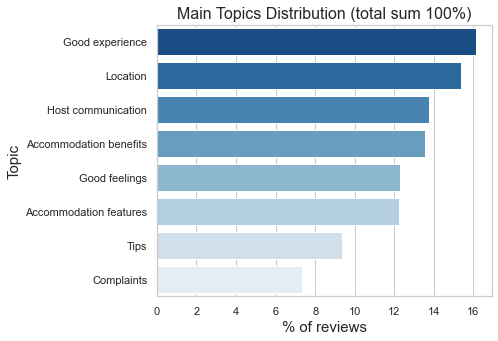

In [38]:
plt.figure(figsize=(6,5))

x = main_topic_dis['Topic']
y = main_topic_dis['percentage']

ax = sns.barplot(x="percentage", y="Topic", data=main_topic_dis,
            label="Total", palette="Blues_r")

ax.set_title('Main Topics Distribution (total sum 100%)', fontsize=16)
ax.set_ylabel('Topic', fontsize=15)
ax.set_xlabel('% of reviews', fontsize=15)


plt.show()

In [45]:
ax.figure.savefig('main_topic_distribution.png',dpi=600, bbox_inches = "tight")

Looking at the **main topic distribution** across our sample of reviews: <br>
- The most discussed topics are **Good experience** and **Location**
- The least discussed topics are **Tips** and **Complaints**

In [25]:
# Remove some outliers in lenght_comments

quantile_95 = df_reviews_sample_sentiment_bitrigrams["length_comments"].quantile(0.95)
df_95 = df_reviews_sample_sentiment_bitrigrams[df_reviews_sample_sentiment_bitrigrams["length_comments"] < quantile_95]

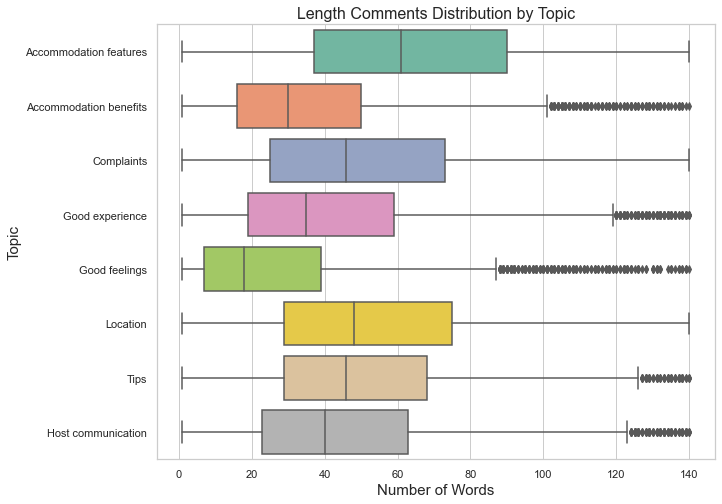

In [72]:
y = df_95["main_topic"].map(topic_list)
x = df_95["length_comments"]

plt.figure(figsize=(10,8))

ax = sns.boxplot(x=x, y=y, data=df_reviews_sample_sentiment_bitrigrams, palette="Set2" )

ax.set_title('Length Comments Distribution by Topic', fontsize=16)
ax.set_ylabel('Topic', fontsize=15)
ax.set_xlabel('Number of Words', fontsize=15)

plt.show()

In [73]:
ax.figure.savefig('length_comments_topic.png',dpi=600, bbox_inches = "tight")

Looking at the **length of comments distribution** by topics: <br>
- The most **wordy** topic is **Accommodation features**
- The most **concise** topic is **Good feelings**
- The most **diverse** topics are **Accommodation features**, **Location**, **Complaints**
- Most topics are **right-skewed**


<a class="anchor" id='chapter4_2_4'></a>
### Evaluate LDA Model

Like each algorithm LDA also needs to evaluate how good the trained model is. There are two convenient measurement techniques:<br>
* **Perplexity Score**: Lower is better
* **Coherence Score**: Higher is better

In [34]:
# Compute Perplexity Score
print('\nPerplexity: ', lda_model_final.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_final, texts=data_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.1401473452000115

Coherence Score:  0.5993569972468963


[Back to TOC](#Table-of-Contents:)
<a class="anchor" id='chapter4.3'></a>
### Visualize topic-keyword of LDA

The next step os to examine the topics from LDA and the associated keywords. <br>
We use the **pyLDAvis** library for interactive topic visualization. pyLDAvis is **designed to help users interpret the topics in a topic model** that has been fit to a corpus of text data. The package extracts information from a fitted LDA topic model to inform an **interactive web-based visualization**. <br>

pyLDAvis attempts to aswer the following questions: <br>
1. What is the meaning of each topic?
2. How prevalent is each topic?
3. How do the topics relate to each other?

**Reference:**<br>
Sievert, Carson, and Kenneth Shirley. "LDAvis: A method for visualizing and interpreting topics." Proceedings of the workshop on interactive language learning, visualization, and interfaces. 2014. https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf <br>
https://pypi.org/project/pyLDAvis/

**Packages** required: <br>
- pyLDAvis
- reload



In [69]:
# To plot inside Jupyter notebook
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model_final, corpus, id2word, sort_topics=False)

# Save pyLDA plot as html file
pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/Users/loredanafattorini/miniforge3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/loredanafattorini/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/loredanafattorini/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/loredanafattorini/miniforge3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.116582  0.287955       1        1   8.874749
1     -0.033068  0.135506       2        1  15.833814
2     -0.165427 -0.158472       3        1  11.153423
3      0.048799 -0.126202       4        1  10.432188
4     -0.131129 -0.000426       5        1  12.780142
5      0.198828 -0.103341       6        1  17.012538
6      0.312008  0.081124       7        1  10.395133
7     -0.113429 -0.116145       8        1  13.518010, topic_info=          Term         Freq        Total Category  logprob  loglift
90        view  4253.000000  4253.000000  Default  30.0000  30.0000
144       give  4642.000000  4642.000000  Default  29.0000  29.0000
78       house  5799.000000  5799.000000  Default  28.0000  28.0000
562       flat  3305.000000  3305.000000  Default  27.0000  27.0000
130      check  4089.000000  4089.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
147      super   746.734633  3615.999702   Topic8  -5.0320   0.4237
1    available   670.074609  2407.595548   Topic8  -5.1403   0.7222
208      photo   631.584319  1806.624424   Topic8  -5.1995   0.9502
271       help   641.213539  3124.777117   Topic8  -5.1843   0.4174
252      equip   629.968811  2723.503882   Topic8  -5.2020   0.5371

[531 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
330       1  0.462410  absolutely
330       2  0.086229  absolutely
330       5  0.201202  absolutely
330       8  0.249611  absolutely
526       1  0.181309  accessible
...     ...       ...         ...
308       6  0.765538        work
308       7  0.111092        work
63        1  0.719795       worth
63        6  0.279481       worth
1674      7  0.992044         ztl

[956 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

Each bubble on the left-hand side of the plot represents an individual topic. The **larger** the **bubble**, the **more important** is the **topic**.<br>
The **distance between the topics** is an approximation of **semantic relationship** between them. Indeed, the topics which share common words are overlapping (closer in distance).
Ideally, a good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one.<br>

On the right-hand side, the **horizontal bar chart** represents the **words distribution a topic decreasing order of relevance**. The **red bar** indicates the **frequency** of the word **within the selected topic**, while the **blue bar** indicates the **frequency within the corpus** of reviews. <br>

**Adjusting λ** (lambda) <br>
If λ=1, the relevance is given purely by the probability of the word to that topic. <br>
If λ=0, the relevance is given by the probability of a word appearing in a particular topic divided by the probability of the word appearing generally — thus, highly frequent words (such as ‘like’, ‘good’) will be downgraded heavily in relevance when we have a lower λ value.


**Some insights**:<br>

- The most important topic is **Accomodation features**
- The least important topic is **Good feelings**
- There is a bit of overalap between topic 3 **Tips** and topic 8 **Good experience**



In [29]:
#df_reviews_sample_sentiment_bitrigrams.to_pickle('./data/df_reviews_sample_topics.pkl')

[Back to TOC](#Table-of-Contents:)